# Analiza kariery piłkarskiej na podstawie przepływu potencjału w świecie piłki nożnej

In [1]:
from contextlib import contextmanager
import pandas as pd
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

@contextmanager
def unlimited_data_card():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)

    yield None

    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

/Users/gal/miniforge3/envs/sc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FIFA_PLAYERS_DATA = list((Path.cwd() / "fifa_players_data").glob("*"))
TOP_DISPLAY = 20

In [3]:
dataframes = []

for fifa_player_data_path, year in zip(sorted(FIFA_PLAYERS_DATA, key=lambda x: int(str(x).removesuffix(".csv").split("_")[-1])), range(15, 22)):
    df = pd.read_csv(fifa_player_data_path)
    df["year"] = year
    dataframes.append(df)

fifa_data = pd.concat(dataframes)

years = list(range(15,22))
print(list(fifa_data.columns))

['sofifa_id', 'player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_ba

In [27]:
import networkx as nx

graphs = {}

for idx, (year_1, year_2) in enumerate(zip(years[:-1], years[1:])):

    year_1_data = fifa_data[fifa_data["year"] == year_1]
    year_2_data = fifa_data[fifa_data["year"] == year_2]

    clubs_2 = year_2_data[["sofifa_id", "club_name", "potential"]].set_index("sofifa_id")
    clubs_1 = year_1_data[["sofifa_id", "club_name", "potential"]].set_index("sofifa_id")
    
    merged = clubs_2.join(clubs_1, how="inner", lsuffix="_last", rsuffix="_next")

    grouped = merged.reset_index().groupby(["club_name_last", "club_name_next"]).mean().drop(columns=["sofifa_id", "potential_last"]).reset_index()
    grouped = grouped[grouped.apply(lambda x: x["club_name_last"] != x["club_name_next"], axis=1)]

    graphs[idx] = nx.from_pandas_edgelist(df=grouped, source="club_name_last", target="club_name_next", edge_attr="potential_next", create_using=nx.DiGraph())

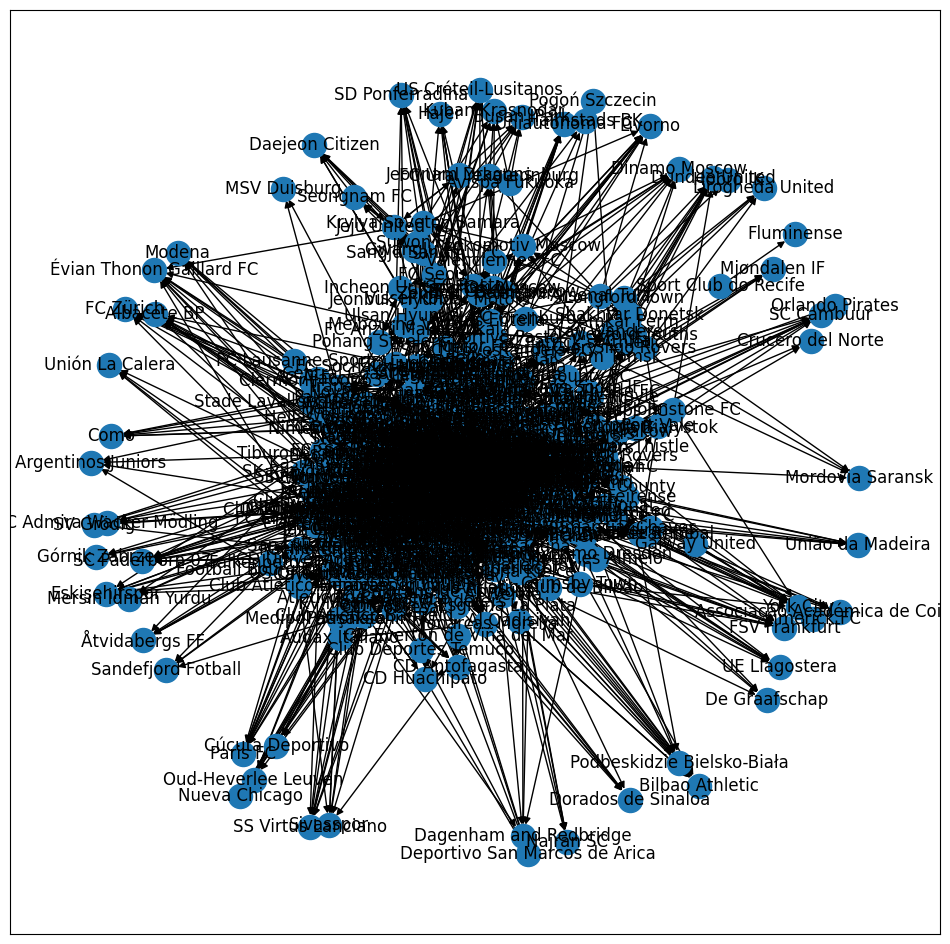

In [29]:
plt.figure(figsize=(12,12))
nx.draw_networkx(graphs[1], with_labels=True)


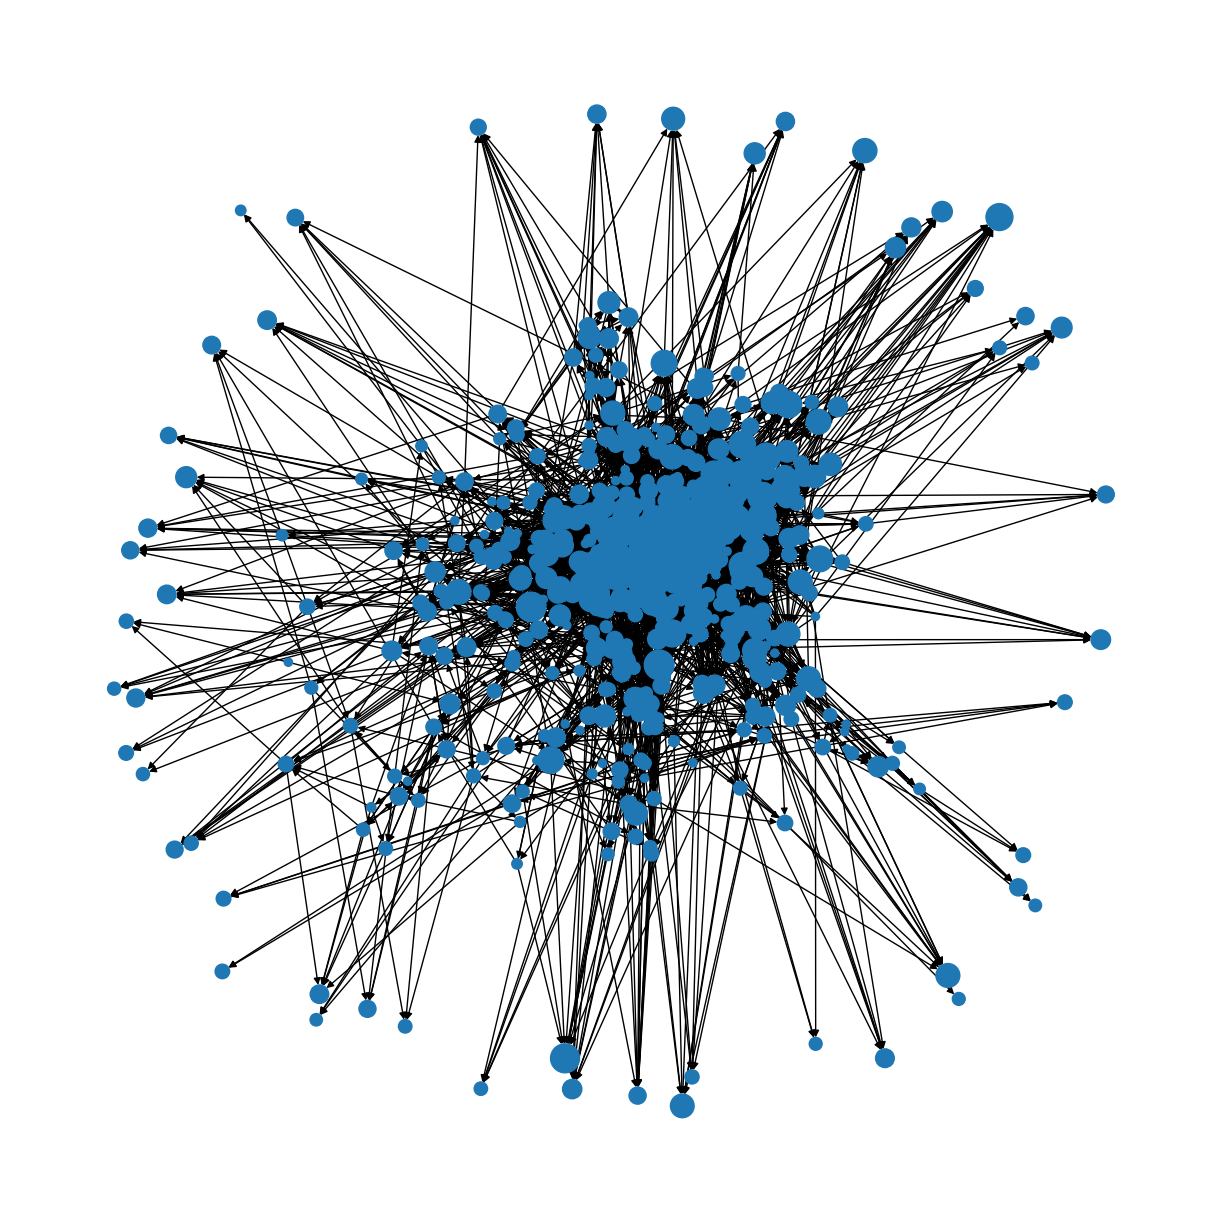

In [32]:
plt.figure(figsize=(12,12))
nx.draw(graphs[0], node_size=[rank * 100000 for rank in nx.pagerank(graphs[0], weight="potential_next").values()], with_labels=False)

In [33]:
groups = list(nx.community.k_clique_communities(graphs[0].to_undirected(), k=3))

colors = ['#000000', '#800000', '#008000', '#808000', '#000080', '#800080', '#008080', '#c0c0c0', '#808080', '#ff0000', '#00ff00', '#ffff00', '#0000ff', '#ff00ff', '#00ffff', '#ffffff', '#000000', '#000033', '#000066', '#000099', '#0000cc', '#0000ff', '#003300', '#003333', '#003366', '#003399', '#0033cc', '#0033ff', '#006600', '#006633', '#006666', '#006699', '#0066cc', '#0066ff', '#009900', '#009933', '#009966', '#009999', '#0099cc', '#0099ff', '#00cc00', '#00cc33', '#00cc66', '#00cc99', '#00cccc', '#00ccff', '#00ff00', '#00ff33', '#00ff66', '#00ff99', '#00ffcc', '#00ffff', '#330000', '#330033', '#330066', '#330099', '#3300cc', '#3300ff', '#333300', '#333333', '#333366', '#333399', '#3333cc', '#3333ff', '#336600', '#336633', '#336666', '#336699', '#3366cc', '#3366ff', '#339900', '#339933']

matching = {}
for group, color in zip(groups, colors):
    for club in group:
        matching[club] = color

In [37]:
communities = nx.community.louvain_communities(graphs[0], weight='weight', resolution=1, threshold=1e-07, seed=None)

[{'1. FC Heidenheim 1846',
  '1. FC Kaiserslautern',
  '1. FC Köln',
  '1. FC Nürnberg',
  '1. FSV Mainz 05',
  'Aalborg BK',
  'Ajax',
  'Bayer 04 Leverkusen',
  'Borussia Dortmund',
  'Borussia Mönchengladbach',
  'Brøndby IF',
  'Eintracht Braunschweig',
  'Eintracht Frankfurt',
  'Esbjerg fB',
  'FC Admira Wacker Mödling',
  'FC Augsburg',
  'FC Basel 1893',
  'FC Bayern München',
  'FC Erzgebirge Aue',
  'FC Ingolstadt 04',
  'FC København',
  'FC Luzern',
  'FC Midtjylland',
  'FC Red Bull Salzburg',
  'FC Schalke 04',
  'FC St. Gallen',
  'FC Twente',
  'FC Vaduz',
  'FK Austria Wien',
  'FSV Frankfurt',
  'Fortuna Düsseldorf',
  'Grasshopper Club Zürich',
  'Hamburger SV',
  'Hannover 96',
  'Hertha BSC',
  'IF Elfsborg',
  'IFK Göteborg',
  'Karlsruher SC',
  'Lechia Gdańsk',
  'MSV Duisburg',
  'Malmö FF',
  'Molde FK',
  'Odds BK',
  'Odense Boldklub',
  'Panathinaikos FC',
  'RB Leipzig',
  'SC Freiburg',
  'SC Heerenveen',
  'SC Paderborn 07',
  'SC Wiener Neustadt',
  'SK

In [38]:
from pyvis.network import Network
import networkx as nx

nt = Network()
nt.from_nx(graphs[0])
nt.show_buttons(filter_=['physics'])
nt.show('nx.html')